<a href="https://colab.research.google.com/github/muxspace/soil_moisture_precipitation/blob/main/Capstone_model_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# model to estimate precipitation
### by- Praveen and Harish

In [1]:
# Precipitation Model from Soil Moisture Sensors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set random seed for reproducibility
np.random.seed(42)


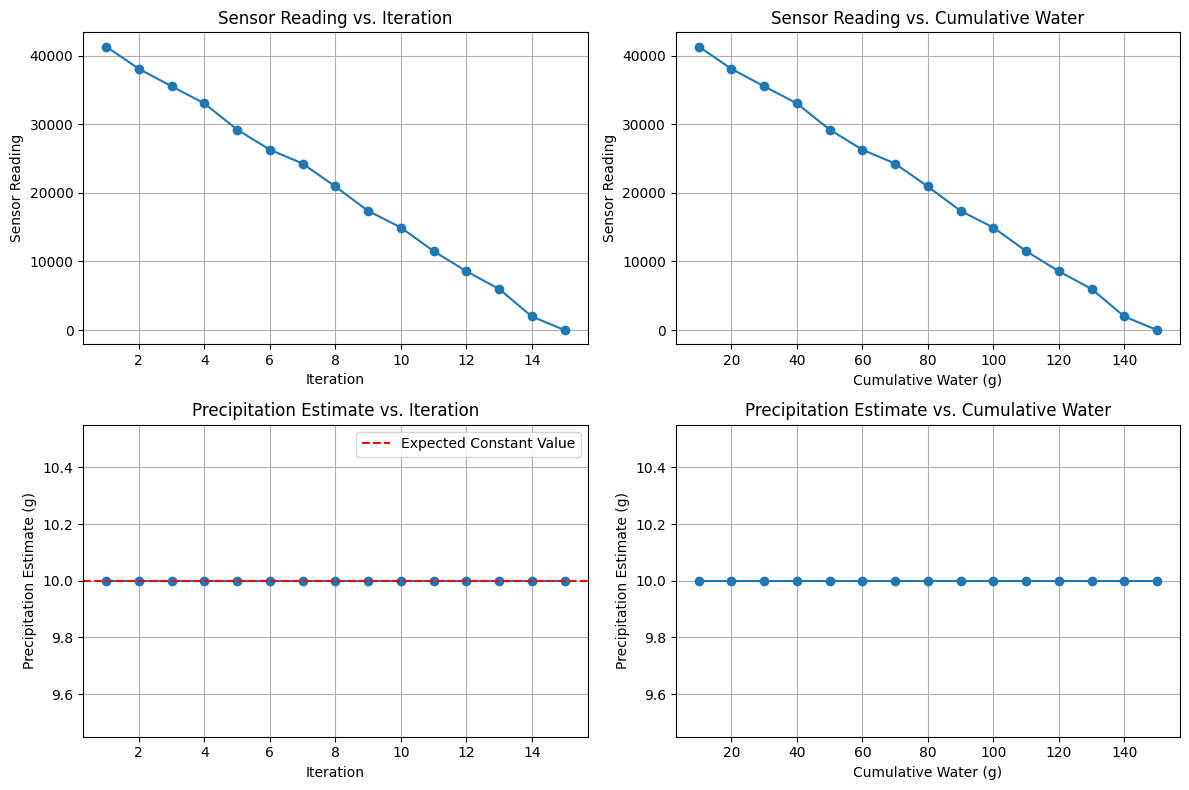

One-sample t-test for constant precipitation:
t-statistic: nan
p-value: nan
If p-value > 0.05, we fail to reject the null hypothesis that precipitation is constant at 10g

Linear regression of precipitation vs. iteration:
Slope: 0.000000
p-value: 1.0000
If p-value > 0.05, we fail to reject the null hypothesis that there's no trend in precipitation


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [2]:

# Constants
DRY_SOIL_READING = 44000  # Sensor reading for dry soil
SATURATED_SOIL_READING = 0  # Sensor reading for saturated soil

## Part 1: Constant Water Addition Experiment

# Simulate data for the first experiment (constant water addition)
def simulate_constant_water_experiment(num_iterations=10, water_mass=10,
                                      initial_sensor_reading=DRY_SOIL_READING,
                                      noise_level=500):
    """
    Simulate data for experiment with constant water addition.

    Parameters:
    -----------
    num_iterations : int
        Number of water additions
    water_mass : float
        Mass of water added in each iteration (g)
    initial_sensor_reading : int
        Initial sensor reading for dry soil
    noise_level : float
        Standard deviation of noise to add to readings

    Returns:
    --------
    DataFrame with experiment data
    """
    # Initialize data storage
    data = []

    # Calculate theoretical decrease in sensor reading per water addition
    # Assuming a linear relationship between water added and sensor reading
    max_total_water = num_iterations * water_mass
    reading_decrease_per_unit = (initial_sensor_reading - SATURATED_SOIL_READING) / max_total_water

    # Generate data
    cumulative_water = 0
    current_reading = initial_sensor_reading

    for i in range(num_iterations):
        # Add water
        cumulative_water += water_mass

        # Calculate theoretical reading
        theoretical_reading = initial_sensor_reading - (cumulative_water * reading_decrease_per_unit)

        # Add some noise to the reading
        actual_reading = max(SATURATED_SOIL_READING,
                            min(initial_sensor_reading,
                                theoretical_reading + np.random.normal(0, noise_level)))

        # Record data
        data.append({
            'iteration': i + 1,
            'water_added_g': water_mass,
            'cumulative_water_g': cumulative_water,
            'sensor_reading': actual_reading,
            'precipitation_estimate': water_mass  # Constant precipitation
        })

    return pd.DataFrame(data)

# Generate data for constant water experiment
const_water_df = simulate_constant_water_experiment(num_iterations=15, water_mass=10)

# Visualize the data
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(const_water_df['iteration'], const_water_df['sensor_reading'], 'o-')
plt.title('Sensor Reading vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Sensor Reading')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(const_water_df['cumulative_water_g'], const_water_df['sensor_reading'], 'o-')
plt.title('Sensor Reading vs. Cumulative Water')
plt.xlabel('Cumulative Water (g)')
plt.ylabel('Sensor Reading')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(const_water_df['iteration'], const_water_df['precipitation_estimate'], 'o-')
plt.title('Precipitation Estimate vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Precipitation Estimate (g)')
plt.grid(True)
plt.axhline(y=10, color='r', linestyle='--', label='Expected Constant Value')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(const_water_df['cumulative_water_g'], const_water_df['precipitation_estimate'], 'o-')
plt.title('Precipitation Estimate vs. Cumulative Water')
plt.xlabel('Cumulative Water (g)')
plt.ylabel('Precipitation Estimate (g)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Model to verify if precipitation is constant
# We'll use a one-sample t-test to check if the mean precipitation is equal to the expected value
t_stat, p_value = stats.ttest_1samp(const_water_df['precipitation_estimate'], 10)
print(f"One-sample t-test for constant precipitation:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"If p-value > 0.05, we fail to reject the null hypothesis that precipitation is constant at 10g")

# Check for any trend in precipitation estimates
slope, intercept, r_value, p_value, std_err = stats.linregress(const_water_df['iteration'],
                                                            const_water_df['precipitation_estimate'])
print(f"\nLinear regression of precipitation vs. iteration:")
print(f"Slope: {slope:.6f}")
print(f"p-value: {p_value:.4f}")
print(f"If p-value > 0.05, we fail to reject the null hypothesis that there's no trend in precipitation")

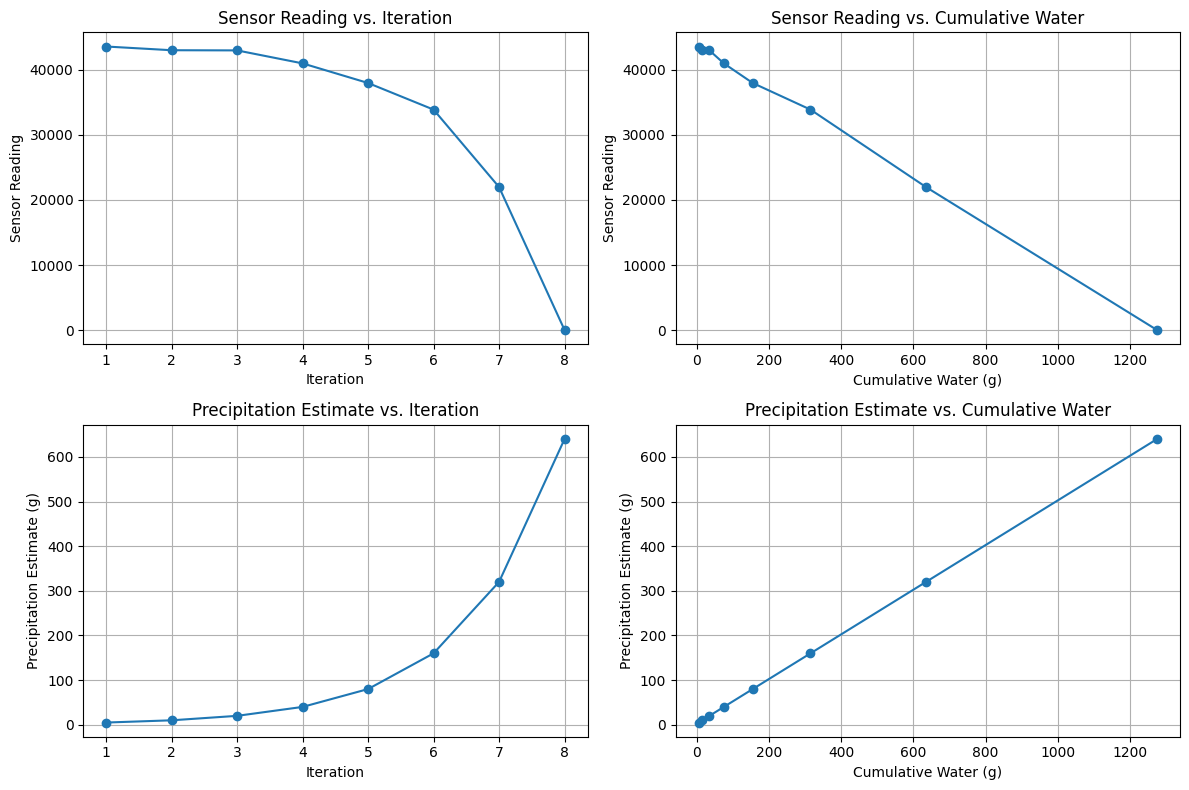

In [3]:
## Part 2: Exponential Water Addition Experiment

# Simulate data for the second experiment (doubling water addition)
def simulate_doubling_water_experiment(num_iterations=8, initial_water_mass=5,
                                      initial_sensor_reading=DRY_SOIL_READING,
                                      noise_level=500):
    """
    Simulate data for experiment with doubling water addition.

    Parameters:
    -----------
    num_iterations : int
        Number of water additions
    initial_water_mass : float
        Initial mass of water added (g)
    initial_sensor_reading : int
        Initial sensor reading for dry soil
    noise_level : float
        Standard deviation of noise to add to readings

    Returns:
    --------
    DataFrame with experiment data
    """
    # Initialize data storage
    data = []

    # Calculate maximum possible water addition
    max_total_water = initial_water_mass * (2**num_iterations - 1)
    reading_decrease_per_unit = (initial_sensor_reading - SATURATED_SOIL_READING) / max_total_water

    # Generate data
    cumulative_water = 0
    current_reading = initial_sensor_reading
    current_water_mass = initial_water_mass

    for i in range(num_iterations):
        # Add water
        cumulative_water += current_water_mass

        # Calculate theoretical reading
        theoretical_reading = initial_sensor_reading - (cumulative_water * reading_decrease_per_unit)

        # Add some noise to the reading
        actual_reading = max(SATURATED_SOIL_READING,
                            min(initial_sensor_reading,
                                theoretical_reading + np.random.normal(0, noise_level)))

        # Record data
        data.append({
            'iteration': i + 1,
            'water_added_g': current_water_mass,
            'cumulative_water_g': cumulative_water,
            'sensor_reading': actual_reading,
            'precipitation_estimate': current_water_mass
        })

        # Double the water mass for next iteration
        current_water_mass *= 2

    return pd.DataFrame(data)

# Generate data for doubling water experiment
doubling_water_df = simulate_doubling_water_experiment(num_iterations=8, initial_water_mass=5)

# Visualize the data
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(doubling_water_df['iteration'], doubling_water_df['sensor_reading'], 'o-')
plt.title('Sensor Reading vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Sensor Reading')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(doubling_water_df['cumulative_water_g'], doubling_water_df['sensor_reading'], 'o-')
plt.title('Sensor Reading vs. Cumulative Water')
plt.xlabel('Cumulative Water (g)')
plt.ylabel('Sensor Reading')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(doubling_water_df['iteration'], doubling_water_df['precipitation_estimate'], 'o-')
plt.title('Precipitation Estimate vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Precipitation Estimate (g)')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(doubling_water_df['cumulative_water_g'], doubling_water_df['precipitation_estimate'], 'o-')
plt.title('Precipitation Estimate vs. Cumulative Water')
plt.xlabel('Cumulative Water (g)')
plt.ylabel('Precipitation Estimate (g)')
plt.grid(True)

plt.tight_layout()
plt.show()


Linear regression of log2(precipitation) vs. iteration:
Slope: 1.0000 (expected: 1.0 for perfect doubling)
R-squared: 1.0000
p-value: 0.0000
If p-value < 0.05 and slope ≈ 1, we confirm exponential growth


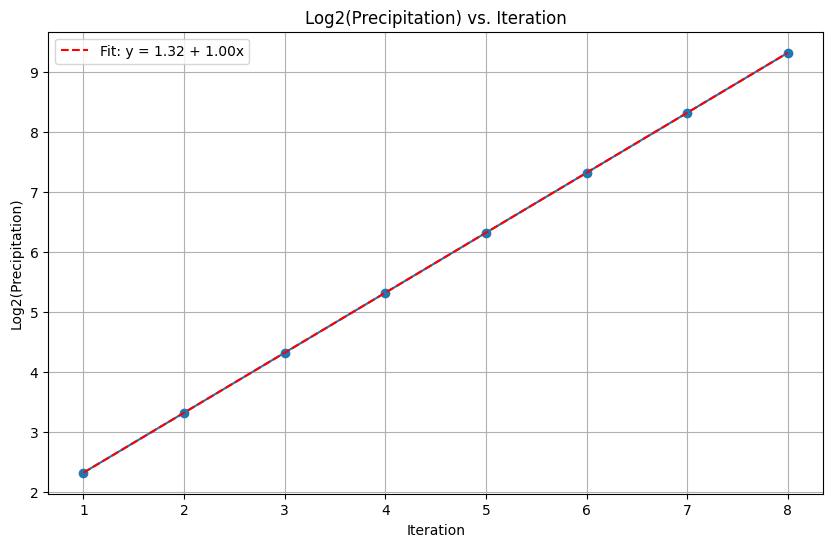

In [4]:


# Model to verify if precipitation follows an exponential growth
# We'll log-transform the data and check if it follows a linear relationship
doubling_water_df['log_precipitation'] = np.log2(doubling_water_df['precipitation_estimate'])

# Linear regression on log-transformed data
slope, intercept, r_value, p_value, std_err = stats.linregress(doubling_water_df['iteration'],
                                                            doubling_water_df['log_precipitation'])
print(f"\nLinear regression of log2(precipitation) vs. iteration:")
print(f"Slope: {slope:.4f} (expected: 1.0 for perfect doubling)")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"If p-value < 0.05 and slope ≈ 1, we confirm exponential growth")

# Visualize the log-transformed data
plt.figure(figsize=(10, 6))
plt.plot(doubling_water_df['iteration'], doubling_water_df['log_precipitation'], 'o-')
plt.title('Log2(Precipitation) vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Log2(Precipitation)')
plt.grid(True)

# Add the regression line
x = np.array(doubling_water_df['iteration'])
plt.plot(x, intercept + slope*x, 'r--', label=f'Fit: y = {intercept:.2f} + {slope:.2f}x')
plt.legend()
plt.show()
